In [1]:
%load_ext autoreload
%autoreload 1

%aimport utils
import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML

## Load X/Y from cached files

In [2]:
country = 'USA'
with open(os.path.join(os.getcwd(), 'cache', '%s.pickle' % country), 'rb') as f:
    data = pickle.load(f)

display(HTML('<h4>%s - Features</h4>' % country))
display(data['X'].head(3))

display(HTML('<h4>%s - Labels</h4>' % country))
display(data['Y'].head(3))

display(HTML('<h4>%s - Label Names</h4>' % country))
print(data['Y_Names'])
display(HTML('<hr>'))

,cpi,production,gvnbond10y,3mlibor,unemployment,cpi_diff,production_diff,gvnbond10y_diff,3mlibor_diff,unemployment_diff,QUA,MKT,SMB,HMLFF,HMLDE,UMD,RF,RV30D
DATE,,,,,,,,,,,,,,,,,,
1986-02-01,46.283600,52.5120,8.70,8.0625,7.2,-0.084382,-0.2635,-0.49,0.0625,0.5,0.004053,0.008433,-0.006213,-0.004894,-0.007060,0.002824,0.000279,0.007384
1986-03-01,46.030454,52.3399,7.78,7.8750,7.2,-0.253146,-0.1721,-0.92,-0.1875,0.0,0.000701,-0.003919,0.006875,-0.000649,-0.000400,0.005087,0.000281,0.005911
1986-04-01,45.861689,52.4317,7.30,7.3125,7.1,-0.168764,0.0918,-0.48,-0.5625,-0.1,0.005295,-0.012067,0.007298,0.002114,0.000776,0.003653,0.000254,0.006581


,labels
DATE,
1986-02-01,4
1986-03-01,4
1986-04-01,1


['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD']


## Model Predictions

In [3]:
X = data['X'].shift(1).dropna()
Y = data['Y'].iloc[:, 1:]

In [4]:
rolling = utils.RollingMethod(rolling_bars=120, predict_bars=12)

In [5]:
params_space = {
    "max_depth": [1, 3, 5, 10, 15],
    "n_estimators": [10, 50, 100, 300],
    "bagging_fraction":[0.7, 0.85, 1]
}
model = utils.LightGBM(params_space=params_space)

In [6]:
res = rolling.run(model, data['X'], data['Y'])

In [7]:
display(HTML('<h4>Label Prediction</h4>'))
display(res[0].dropna().head(3))

display(HTML('<h4>Probability</h4>'))
display(res[1].dropna().head(3))

,labels
DATE,
1996-02-01,3.0
1996-03-01,2.0
1996-04-01,4.0


,0,1,2,3,4
DATE,,,,,
1996-02-01,0.105861,0.249913,0.202521,0.256292,0.185412
1996-03-01,0.115414,0.186503,0.247244,0.236995,0.213843
1996-04-01,0.101440,0.239475,0.128263,0.186992,0.343830


## Threshold Analysis

In [8]:
aqr = utils.load_aqr_data(country).dropna()

po = utils.PortfolioOptimizer(
    utils.build_portfolio(aqr),
    aqr['RF'],
    aqr['MKT'],
    country
)

In [9]:
po.get_stats_table()
po.get_best_indicators()
display(HTML('<h4>Without Thresholding</h4>'))
display(po.get_accuracy_performance_from_ind_probla(res[0], res[1], data['Y_Names']).head(3))

display(HTML('<h4>Top Thresholding</h4>'))
display(po.get_accuracy_performance_from_ind_probla(res[0], res[1], data['Y_Names']).sort_values('Accuracy', ascending=False).head(5))

,Thresh,Accuracy,Percentage
0,0.00,0.242754,1.0
1,0.02,0.242754,1.0
2,0.04,0.242754,1.0


,Thresh,Accuracy,Percentage
49,0.98,0.400000,0.018116
18,0.36,0.289062,0.463768
17,0.34,0.286713,0.518116
45,0.90,0.285714,0.050725
21,0.42,0.284404,0.394928


## Portfolio Performance

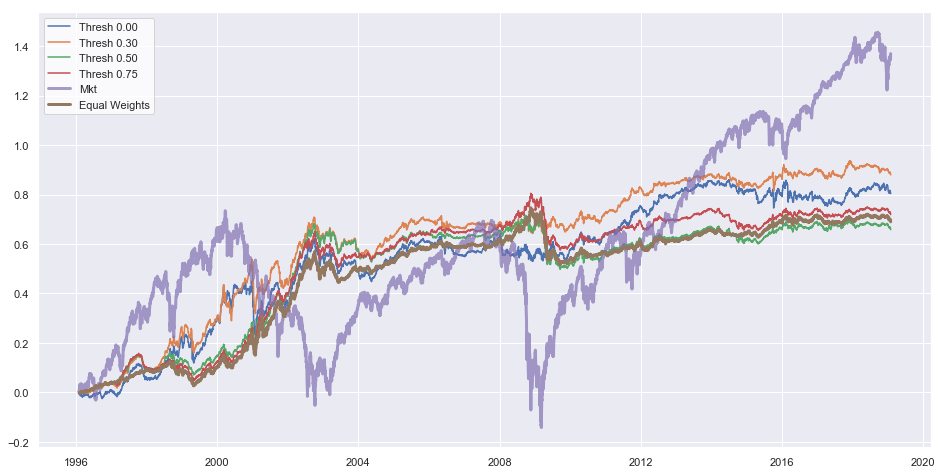

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(16,8))

for thresh in [0, 0.3, 0.5, 0.75]:
    ret = po.get_ret_from_ind_probla(res[0], res[1], data['Y_Names'], thresh)
    ax.plot(np.log(ret + 1).cumsum(), label='Thresh %.2f' % thresh)

ax.plot(np.log(po.market[ret.index] + 1).cumsum(), label='Mkt', alpha=0.7, lw=3)
ax.plot(np.log(po.portfolios['equal_weights'][ret.index] + 1).cumsum(), label='Equal Weights', lw=3)

ax.legend()